In [34]:
# Import required dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
import pipeline_utilities as p_utils
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from prophet import Prophet
import numpy as np
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Exploration

In [35]:
# Import data file
file_path = 'Resources/summer.csv'
df = pd.read_csv(file_path)
df.head()

,Year,City,Sport,Discipline,Athlete,Country,Gender,Event,Medal
0,1896,Athens,Aquatics,Swimming,"HAJOS, Alfred",HUN,Men,100M Freestyle,Gold
1,1896,Athens,Aquatics,Swimming,"HERSCHMANN, Otto",AUT,Men,100M Freestyle,Silver
2,1896,Athens,Aquatics,Swimming,"DRIVAS, Dimitrios",GRE,Men,100M Freestyle For Sailors,Bronze
3,1896,Athens,Aquatics,Swimming,"MALOKINIS, Ioannis",GRE,Men,100M Freestyle For Sailors,Gold
4,1896,Athens,Aquatics,Swimming,"CHASAPIS, Spiridon",GRE,Men,100M Freestyle For Sailors,Silver


In [36]:
#Get info on all features and target
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31165 entries, 0 to 31164
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        31165 non-null  int64 
 1   City        31165 non-null  object
 2   Sport       31165 non-null  object
 3   Discipline  31165 non-null  object
 4   Athlete     31165 non-null  object
 5   Country     31161 non-null  object
 6   Gender      31165 non-null  object
 7   Event       31165 non-null  object
 8   Medal       31165 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.1+ MB


In [38]:
#get medal count by country - top 5
top_five = df.groupby('Country').agg(Medal_count=('Medal','count')).sort_values('Medal_count', ascending=False).reset_index()
top_five.head()

,Country,Medal_count
0,USA,4585
1,URS,2049
2,GBR,1720
3,FRA,1396
4,GER,1305


In [39]:
#get medal count by year, country 
medal_ct_country = df.groupby(['Year','Country']).agg(Medal_count=('Medal','count')).sort_values('Medal_count', ascending=False).reset_index()
medal_ct_country.head()

,Year,Country,Medal_count
0,1980,URS,442
1,1904,USA,394
2,1908,GBR,347
3,1984,USA,333
4,2008,USA,315


In [40]:
#get medal count by year, country, medal groupings
medal_type_ct_country = df.groupby(['Year','Country','Medal']).agg(Medal_count=('Medal','count')).sort_values('Medal_count', ascending=False).reset_index()
medal_type_ct_country.head()

,Year,Country,Medal,Medal_count
0,1980,URS,Gold,192
1,1984,USA,Gold,168
2,1996,USA,Gold,160
3,2012,USA,Gold,147
4,1904,USA,Gold,146


In [41]:
#select USA and set year as index
usa_metal_type_df = medal_type_ct_country.loc[medal_type_ct_country['Country']=='USA'].sort_values(by=['Year'])
usa_metal_type_df.set_index('Year',inplace=True)
usa_metal_type_df.head()


,Country,Medal,Medal_count
Year,,,
1896,USA,Bronze,2
1896,USA,Silver,7
1896,USA,Gold,11
1900,USA,Silver,14
1900,USA,Bronze,14


In [42]:
#select USA and set year as index
usa_df = medal_ct_country.loc[medal_ct_country['Country']=='USA'].sort_values(by=['Year'])
usa_df.set_index('Year',inplace=True)
usa_df.head()


,Country,Medal_count
Year,,
1896,USA,20
1900,USA,55
1904,USA,394
1908,USA,63
1912,USA,101


<Axes: title={'center': 'USA Medal Count from 1896 to 2012'}, xlabel='Year'>

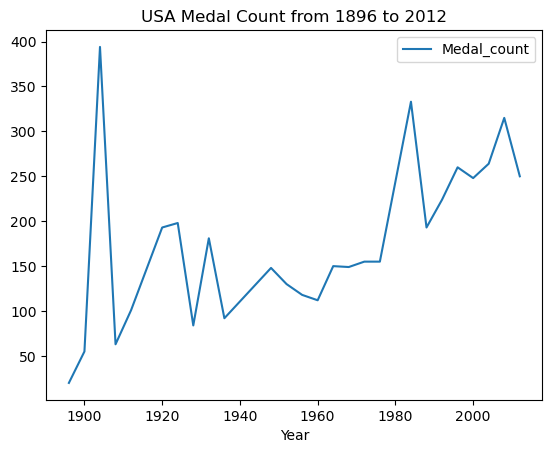

In [43]:
#plot the dataframe
usa_df.plot(title='USA Medal Count from 1896 to 2012')

<Axes: title={'center': 'USA Medal Count from 1896 to 2012'}, xlabel='Year', ylabel='Medal_count'>

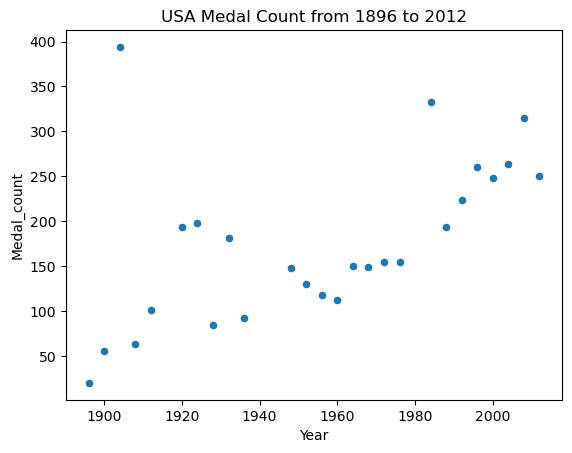

In [44]:
# Create a scatter plot for USA medal counts over the years
usa_df.reset_index(inplace=True)
usa_plot = usa_df.plot.scatter(
    x='Year',
    y='Medal_count',
    title='USA Medal Count from 1896 to 2012'
)
usa_plot

In [45]:
# Use the corr function to compute the correlation between year and medal count
usa_corr = usa_df[['Year','Medal_count']].corr()
usa_corr

,Year,Medal_count
Year,1.000000,0.529927
Medal_count,0.529927,1.000000


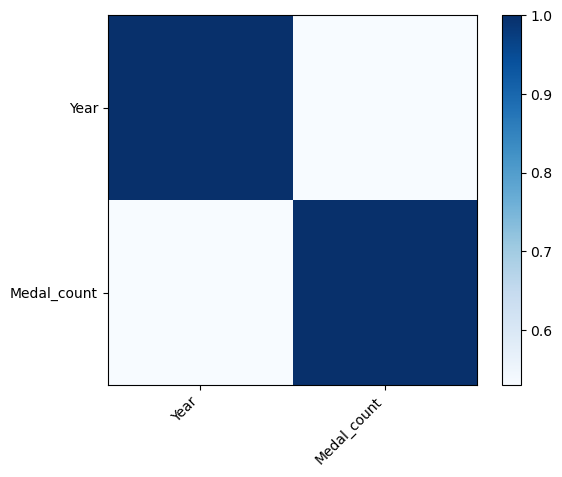

In [46]:
import matplotlib.pyplot as plt
plt.imshow(usa_corr, cmap='Blues')
plt.colorbar()
variables = ['Year','Medal_count']
plt.xticks(range(len(variables)), variables, rotation=45, ha='right')
plt.yticks(range(len(variables)), variables)
plt.show()

In [47]:
# Use pandas to find potential outliers by calculating the interquartile range (IQR)
medal_ct =usa_df['Medal_count']

Q1 = medal_ct.quantile(0.25)
median = medal_ct.quantile(0.5)
Q3 = medal_ct.quantile(0.75)
IQR = Q3 - Q1

print(f"The lower quartile of medal count is: {Q1}")
print(f"The upper quartile of medal count is: {Q3}")
print(f"The interquartile range of medal count is: {IQR}")
print(f"The the median of medal count is: {median} ")

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")


The lower quartile of medal count is: 113.5
The upper quartile of medal count is: 242.0
The interquartile range of medal count is: 128.5
The the median of medal count is: 155.0 
Values below -79.25 could be outliers.
Values above 434.75 could be outliers.


In [48]:
# remove data outliers based on historical events 
# removing years 1904(Russian/Japanese war & first time Olympics hosted outside of Europe) and 1984 (most communist countries boycotted the Olympics)
usa_trimmed_df = usa_df.drop([2,18])
usa_trimmed_df.head()

,Year,Country,Medal_count
0,1896,USA,20
1,1900,USA,55
3,1908,USA,63
4,1912,USA,101
5,1920,USA,193


<Axes: title={'center': 'USA Medal Count from 1896 to 2012 w/o Outliers'}, xlabel='Year', ylabel='Medal_count'>

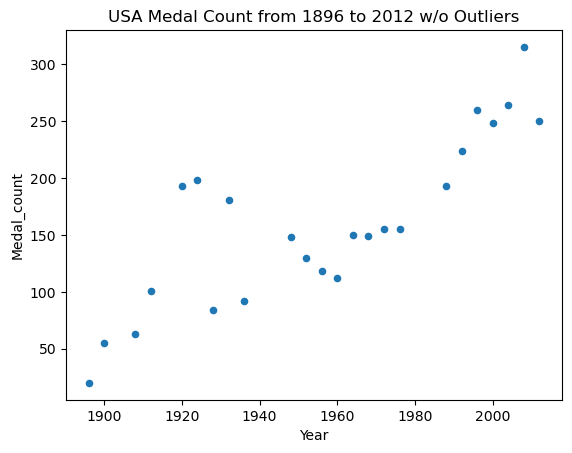

In [49]:
# Create a scatter plot for USA medal counts over the years for new dataframe without outlier years
usa_plot = usa_trimmed_df.plot.scatter(
    x='Year',
    y='Medal_count',
    title='USA Medal Count from 1896 to 2012 w/o Outliers'
)
usa_plot

In [50]:
# Use the corr function to compute the correlation between year and medal count
usa_corr_trimmed = usa_trimmed_df[['Year','Medal_count']].corr()
usa_corr

,Year,Medal_count
Year,1.000000,0.529927
Medal_count,0.529927,1.000000


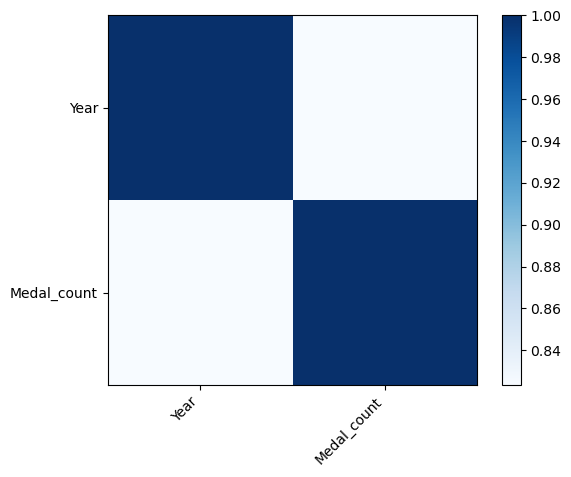

In [51]:
plt.imshow(usa_corr_trimmed, cmap='Blues')
plt.colorbar()
variables = ['Year','Medal_count']
plt.xticks(range(len(variables)), variables, rotation=45, ha='right')
plt.yticks(range(len(variables)), variables)
plt.show()


# Time Series Forecasting Projections Using Prophet

In [52]:
#drop the country column
prophet_df = usa_trimmed_df.drop('Country', axis=1)

In [53]:
#convert year to datetime
prophet_df['Year'] = pd.to_datetime(prophet_df['Year'], format='%Y')

In [54]:
# Prepare the training data to be read into a prophet model
# Rename the columns to names that Prophet recognizes
prophet_df.columns = ['ds', 'y']
prophet_df.head()


,ds,y
0,1896-01-01,20
1,1900-01-01,55
3,1908-01-01,63
4,1912-01-01,101
5,1920-01-01,193


In [55]:
# Confirm that there are no NaN values
prophet_df = prophet_df.dropna()
prophet_df.tail()

,ds,y
21,1996-01-01,260
22,2000-01-01,248
23,2004-01-01,264
24,2008-01-01,315
25,2012-01-01,250


In [56]:
prophet_df.shape

(24, 2)

In [57]:
# Call the Prophet function and store as an object
m = Prophet()

In [58]:
# Fit the time series Prophet model
m.fit(prophet_df)

15:34:34 - cmdstanpy - INFO - Chain [1] start processing
15:34:34 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
# Create a future DataFrame to hold predictions
future = m.make_future_dataframe(periods=13,freq='Y')


# Review the first and last 10 rows of the DataFrame
future.tail(13)

,ds
24,2012-12-31
25,2013-12-31
26,2014-12-31
27,2015-12-31
28,2016-12-31
29,2017-12-31
30,2018-12-31
31,2019-12-31
32,2020-12-31
33,2021-12-31


In [60]:
future.drop(index=[24,25,26,27,29,30,31,33,34,35],inplace=True)
future.reset_index(inplace=True)
future.tail()

,index,ds
22,22,2008-01-01
23,23,2012-01-01
24,28,2016-12-31
25,32,2020-12-31
26,36,2024-12-31


In [61]:
# Make a forecast based on the future DataFrame
forecast = m.predict(future)

# Review the first five rows of the forecast DataFrame
display(forecast.head())
display(forecast.tail())


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1896-01-01,1.269428,-18.666116,84.580974,1.269428,1.269428,33.134090,33.134090,33.134090,33.134090,33.134090,33.134090,0.0,0.0,0.0,34.403518
1,1900-01-01,7.529299,-14.285683,88.374121,7.529299,7.529299,33.134090,33.134090,33.134090,33.134090,33.134090,33.134090,0.0,0.0,0.0,40.663389
2,1908-01-01,20.044757,38.791995,139.392219,20.044757,20.044757,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,88.009578
3,1912-01-01,26.304628,39.797149,150.594513,26.304628,26.304628,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,94.269449
4,1920-01-01,38.824370,58.507688,158.850813,38.824370,38.824370,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,106.789191


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
22,2008-01-01,176.541831,194.761590,298.884369,176.541831,176.541831,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,244.506651
23,2012-01-01,182.801726,198.484310,299.179556,182.801726,182.801726,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,250.766547
24,2016-12-31,190.625524,216.937513,317.163455,190.625523,190.625524,76.556113,76.556113,76.556113,76.556113,76.556113,76.556113,0.0,0.0,0.0,267.181637
25,2020-12-31,196.885419,223.537763,324.892099,196.885416,196.885422,76.556113,76.556113,76.556113,76.556113,76.556113,76.556113,0.0,0.0,0.0,273.441532
26,2024-12-31,203.145314,227.756699,332.485389,203.145309,203.145320,76.556113,76.556113,76.556113,76.556113,76.556113,76.556113,0.0,0.0,0.0,279.701427


/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


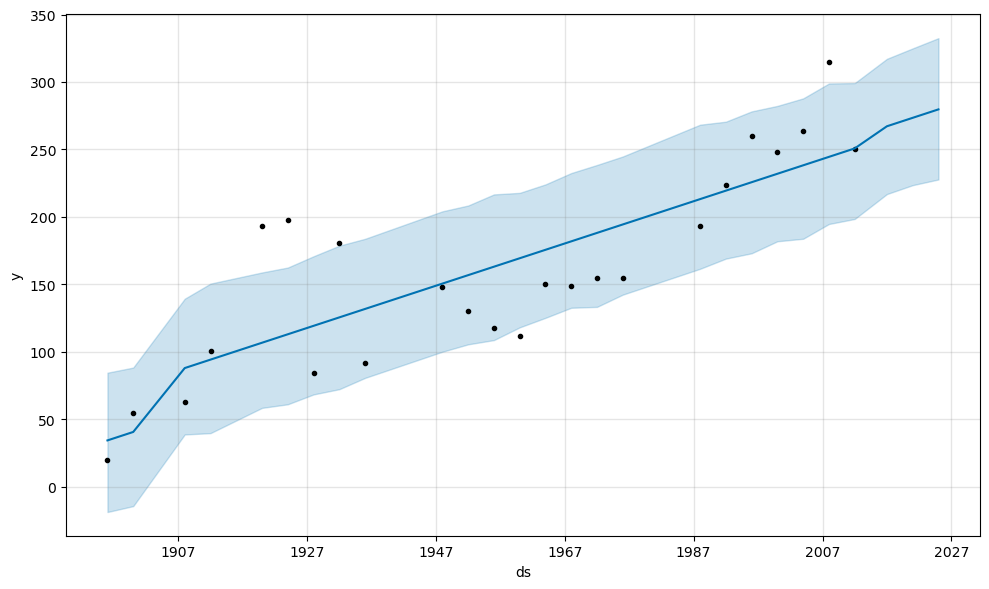

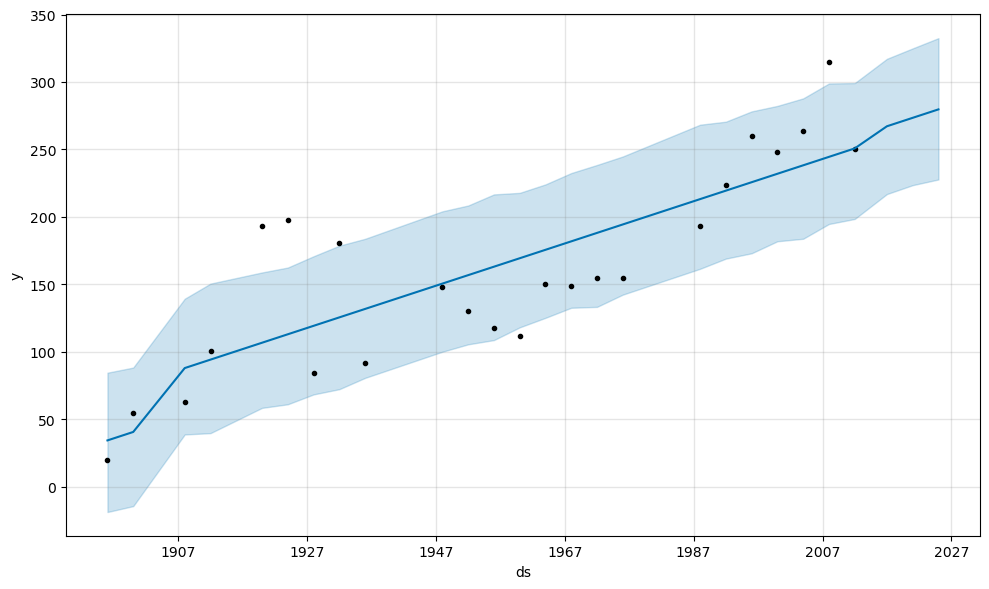

In [62]:
# Plot the forecast using the model’s plot function
m.plot(forecast)

In [63]:
#Plot the Upper and Lower Bounds of the Forecast
# Reset the index to this datetime column so that our plot looks nice
forecast = forecast.set_index('ds')

# Display the DataFrame
forecast.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
1896-01-01,1.269428,-18.666116,84.580974,1.269428,1.269428,33.134090,33.134090,33.134090,33.134090,33.134090,33.134090,0.0,0.0,0.0,34.403518
1900-01-01,7.529299,-14.285683,88.374121,7.529299,7.529299,33.134090,33.134090,33.134090,33.134090,33.134090,33.134090,0.0,0.0,0.0,40.663389
1908-01-01,20.044757,38.791995,139.392219,20.044757,20.044757,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,88.009578
1912-01-01,26.304628,39.797149,150.594513,26.304628,26.304628,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,94.269449
1920-01-01,38.824370,58.507688,158.850813,38.824370,38.824370,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,106.789191


<Axes: xlabel='ds'>

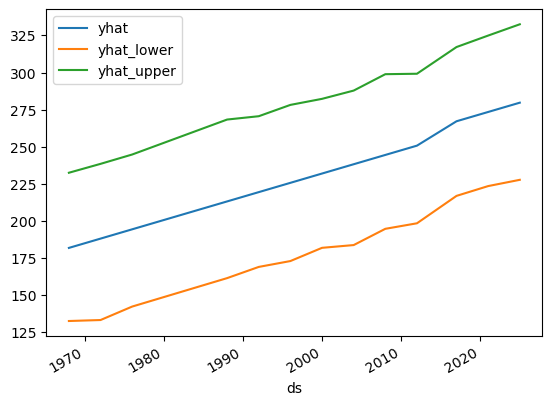

In [64]:
# Plot predictions for our forecast period
forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-13:,:].plot()

/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

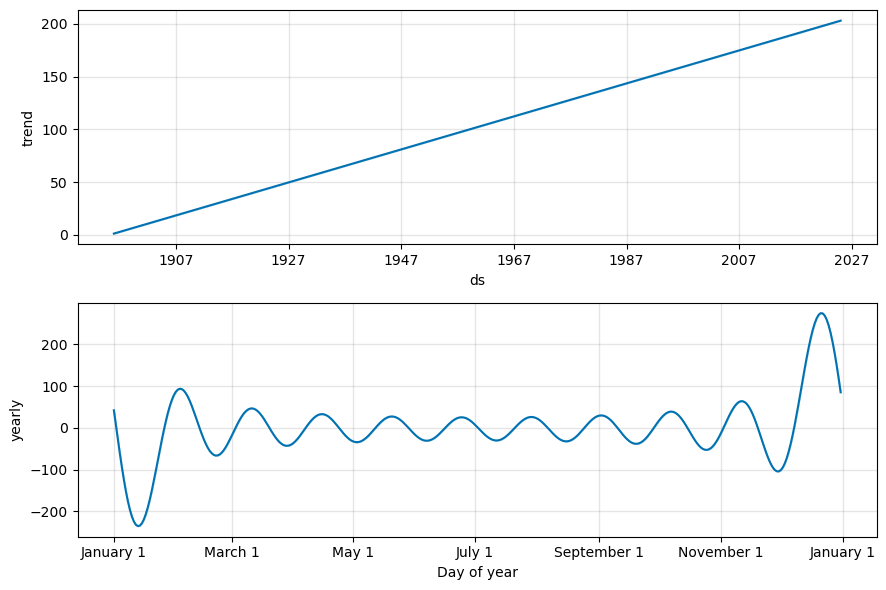

In [65]:
# Reset "ds" from the datetime index back to a column
forecast = forecast.reset_index()

# Plot the individual time series components of the model
fig2 = m.plot_components(forecast)

In [66]:
# Perform cross-validation
df_cv = cross_validation(m, initial='14600 days',period='1460 days',horizon='2920 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

  0%|          | 0/15 [00:00<?, ?it/s]

15:34:35 - cmdstanpy - INFO - Chain [1] start processing
15:34:35 - cmdstanpy - INFO - Chain [1] done processing
15:34:35 - cmdstanpy - INFO - Chain [1] start processing
15:34:35 - cmdstanpy - INFO - Chain [1] done processing
15:34:35 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1]

Mean Absolute Error: 40.59
Mean Squared Error: 2291.68
Root Mean Squared Error: 47.87


# Evaluate p-values for Regression Models

In [67]:
df.head()

,Year,City,Sport,Discipline,Athlete,Country,Gender,Event,Medal
0,1896,Athens,Aquatics,Swimming,"HAJOS, Alfred",HUN,Men,100M Freestyle,Gold
1,1896,Athens,Aquatics,Swimming,"HERSCHMANN, Otto",AUT,Men,100M Freestyle,Silver
2,1896,Athens,Aquatics,Swimming,"DRIVAS, Dimitrios",GRE,Men,100M Freestyle For Sailors,Bronze
3,1896,Athens,Aquatics,Swimming,"MALOKINIS, Ioannis",GRE,Men,100M Freestyle For Sailors,Gold
4,1896,Athens,Aquatics,Swimming,"CHASAPIS, Spiridon",GRE,Men,100M Freestyle For Sailors,Silver


In [68]:
#isolate USA data 
usa_df = df.loc[df['Country']=='USA']

In [69]:
d = {'nunique':['Sport','Discipline','Athlete','Gender','Event'],'count':['Medal']}
usa_grouped_df = usa_df.groupby(['Year']).agg({k: v for v,l in d.items() for k in l})
usa_grouped_df.reset_index(inplace=True)
usa_grouped_df.head(10)

,Year,Sport,Discipline,Athlete,Gender,Event,Medal
0,1896,2,2,12,1,12,20
1,1900,6,6,37,2,24,55
2,1904,16,17,270,2,89,394
3,1908,6,7,51,1,32,63
4,1912,5,5,69,1,39,101
5,1920,11,12,133,2,62,193
6,1924,11,13,172,2,59,198
7,1928,6,7,73,2,33,84
8,1932,12,16,161,2,61,181
9,1936,10,11,82,2,34,92


In [70]:
# get list of Year in descending order for ordinal encoder
years = usa_grouped_df['Year'].sort_values().unique()

In [71]:
# Create an encoder for the categorical ordinal column for 
year_ord_enc = OrdinalEncoder(categories=[years],
                                            encoded_missing_value=-1, 
                                            handle_unknown='use_encoded_value', 
                                            unknown_value=-1)
# Set up the OneHotEncoder so it will transform to Pandas
year_ord_enc.set_output(transform="pandas")


# Fit and transform the OneHotEncoder to the columns to encode
year_ord_enc = year_ord_enc.fit_transform(usa_grouped_df[['Year']])
year_ord_enc.head()

,Year
0,0.0
1,1.0
2,2.0
3,3.0
4,4.0


In [72]:
#concat above dataframes
df_enc = pd.concat([usa_grouped_df,year_ord_enc],axis=1)
df_enc = df_enc.iloc[:,1:]
df_enc.head()

,Sport,Discipline,Athlete,Gender,Event,Medal,Year
0,2,2,12,1,12,20,0.0
1,6,6,37,2,24,55,1.0
2,16,17,270,2,89,394,2.0
3,6,7,51,1,32,63,3.0
4,5,5,69,1,39,101,4.0


In [73]:
#get the features
X = df_enc.drop(columns=['Medal'])
X.head()

,Sport,Discipline,Athlete,Gender,Event,Year
0,2,2,12,1,12,0.0
1,6,6,37,2,24,1.0
2,16,17,270,2,89,2.0
3,6,7,51,1,32,3.0
4,5,5,69,1,39,4.0


In [74]:
#get target column
y=usa_grouped_df['Medal'].values.reshape(-1,1)

In [75]:
#train-test-split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [76]:
import statsmodels.api as sm

# Use the statsmodels package to create and fit a linear regression
lr = sm.OLS(y_train, X_train).fit()

In [77]:
# Show the p-values of all columns sorted in ascending order
lr.pvalues.sort_values(ascending=False)

Year          0.739321
Gender        0.485008
Event         0.352957
Sport         0.231468
Discipline    0.161015
Athlete       0.000046
dtype: float64

In [78]:
#get the features - Remove Ordinal Encoder for Year
X = usa_grouped_df.drop(columns=['Medal'])
X.head()

,Year,Sport,Discipline,Athlete,Gender,Event
0,1896,2,2,12,1,12
1,1900,6,6,37,2,24
2,1904,16,17,270,2,89
3,1908,6,7,51,1,32
4,1912,5,5,69,1,39


In [79]:
#get target column
y=usa_grouped_df['Medal'].values.reshape(-1,1)

#train-test-split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [80]:
# Use the statsmodels package to create and fit a linear regression
lr = sm.OLS(y_train, X_train).fit()

# Show the p-values of all columns sorted in ascending order
lr.pvalues.sort_values(ascending=False)

Year          0.959500
Gender        0.642894
Event         0.420766
Sport         0.145625
Discipline    0.018035
Athlete       0.000018
dtype: float64

In [81]:
# Group by USA and medal count (all features)
# grouped_df = df.groupby(['Year','City','Sport','Discipline','Athlete','Country','Gender','Event'])\
#             .agg(Medal_count=('Medal','count')).sort_values('Medal_count', ascending=False).reset_index()

# usa_grouped_df = grouped_df.loc[grouped_df['Country']=='USA']
# usa_grouped_df.head()

# #remove outlier years
# #usa_grouped_df_trimmed = usa_grouped_df.loc[usa_grouped_df['Year']!= []]

In [82]:
# encode columns
# columns_to_encode = ['City','Sport','Discipline','Athlete','Country','Gender','Event']

# # Create an encoder for the categorical columns
# ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# # Set up the OneHotEncoder so it will transform to Pandas
# ohe.set_output(transform="pandas")

# # Fit and transform the OneHotEncoder to the columns to encode
# usa_data_ohe = ohe.fit_transform(usa_grouped_df[columns_to_encode])
# usa_data_ohe.tail()

# Use Model Generator Pipeline to Evaluate Three Models

In [83]:
#drop unnecessary columns based on low p-values: Event, Sport, Discipline, Athelete
clean_df = p_utils.drop_columns(usa_grouped_df)
clean_df.head()

,Year,Gender,Event,Medal
0,1896,1,12,20
1,1900,2,24,55
2,1904,2,89,394
3,1908,1,32,63
4,1912,1,39,101


In [84]:
#run model generator function from python file
p_utils.medal_model_generator(clean_df)

Testing Linear Regression
Mean Squared Error: 2217.243981038019
R-squared: 0.7700888895383726
Adjusted R-squared: 0.5401777790767452
------------------------------------------
Testing Random Forest Regressor
Mean Squared Error: 1401.2216571428569
R-squared: 0.8547041146794427
Adjusted R-squared: 0.7094082293588855
------------------------------------------
Testing XGB Regressor
Mean Squared Error: 810.782031145057
R-squared: 0.9159281528252811
Adjusted R-squared: 0.8318563056505621
------------------------------------------
Testing SVR Regressor
Mean Squared Error: 9701.505375818948
R-squared: -0.005971328901641426
Adjusted R-squared: -1.0119426578032829
------------------------------------------
XGB Regressor is the best model.


/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('XGB Regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [85]:
# remove year outliers based on historical events 
# removing years 1904(Russian/Japanese war & first time Olympics hosted outside of Europe) and 1984 (most communist countries boycotted the Olympics)
final_df = clean_df.drop([2,18])
final_df.head()

,Year,Gender,Event,Medal
0,1896,1,12,20
1,1900,2,24,55
3,1908,1,32,63
4,1912,1,39,101
5,1920,2,62,193


In [86]:
pipeline = p_utils.medal_model_generator(final_df)
print(p_utils.medal_model_generator(final_df))

Testing Linear Regression
Mean Squared Error: 2438.4737845474565
R-squared: 0.7254967033868203
Adjusted R-squared: 0.31374175846705066
------------------------------------------
Testing Random Forest Regressor
Mean Squared Error: 1326.4205166666663
R-squared: 0.8506825019700059
Adjusted R-squared: 0.6267062549250149
------------------------------------------
Testing XGB Regressor
Mean Squared Error: 1213.4647461018492
R-squared: 0.8633981323729297
Adjusted R-squared: 0.6584953309323243
------------------------------------------
Testing SVR Regressor
Mean Squared Error: 9425.477003773261
R-squared: -0.06104257756769127
Adjusted R-squared: -1.652606443919228
------------------------------------------
XGB Regressor is the best model.
Testing Linear Regression
Mean Squared Error: 1974.4249829366424
R-squared: 0.7909290940689544
Adjusted R-squared: 0.477322735172386
------------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Testing Random Forest Regressor
Mean Squared Error: 1252.5730333333333
R-squared: 0.8673656476761663
Adjusted R-squared: 0.6684141191904158
------------------------------------------
Testing XGB Regressor
Mean Squared Error: 854.417036273701
R-squared: 0.909526193519405
Adjusted R-squared: 0.7738154837985125
------------------------------------------
Testing SVR Regressor
Mean Squared Error: 10025.265054804217
R-squared: -0.06157046498131269
Adjusted R-squared: -1.6539261624532817
------------------------------------------
XGB Regressor is the best model.
Pipeline(steps=[('XGB Regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, ga

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [96]:
# get predictions from test dataset by implementing winning model
X = final_df.drop(columns='Medal')
y = final_df['Medal'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
y_pred = pipeline.predict(X_test)

In [118]:
#display predictions vs actuals in a dataframe
x_test_df = X_test.reset_index(drop=True)
y_test_df = pd.DataFrame(y_test).rename(columns={0:'Medal_Ct'})
y_pred_df = pd.DataFrame(y_pred).rename(columns={0:'Predicted_Medal_Ct'}).round()

test_df = pd.concat([x_test_df,y_test_df,y_pred_df],axis=1)
test_df['Prediction vs Actual'] = test_df['Predicted_Medal_Ct'] - test_df['Medal_Ct']
test_df.sort_values('Year',inplace=True)
test_df.reset_index(drop=True,inplace=True)
test_df

,Year,Gender,Event,Medal_Ct,Predicted_Medal_Ct,Prediction vs Actual
0,1908,1,32,63,55.0,-8.0
1,1960,2,48,112,112.0,0.0
2,1964,2,55,150,150.0,0.0
3,1992,2,77,224,224.0,0.0
4,2000,2,65,248,248.0,0.0
5,2004,2,65,264,248.0,-16.0


In [119]:
test_df

,Year,Gender,Event,Medal_Ct,Predicted_Medal_Ct,Prediction vs Actual
0,1908,1,32,63,55.0,-8.0
1,1960,2,48,112,112.0,0.0
2,1964,2,55,150,150.0,0.0
3,1992,2,77,224,224.0,0.0
4,2000,2,65,248,248.0,0.0
5,2004,2,65,264,248.0,-16.0


<Axes: title={'center': 'Predicted Medal Counts vs Actuals'}, xlabel='Year'>

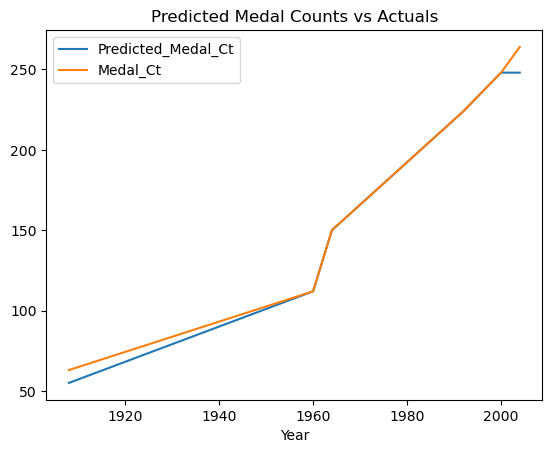

In [121]:
#plot results 
test_df_plot = test_df.set_index('Year')
test_df_plot[['Predicted_Medal_Ct','Medal_Ct']].plot(title='Predicted Medal Counts vs Actuals')


# Hyperparameter

In [90]:
# 
# Create the grid search estimator along with a parameter object containing the values to adjust.
# Try adjusting n_neighbors with values of 1 through 19. Adjust leaf_size by using 10, 50, 100, and 500.
# Include both uniform and distance options for weights.
# from sklearn.model_selection import GridSearchCV
# param_grid = {
    
# }
# grid_clf = GridSearchCV(grid_tuned_model, param_grid, verbose=3)

In [91]:
# Fit the model by using the randomized search estimator.
# random_clf.fit(X_train, y_train)